In [56]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

### Load data

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
data = pd.read_csv("raw_combined_2.csv") 

# get the length of section
print("Total number of texts: ", len(data['text']))
print("Total number of labels: ", len(data['label']))

#get unique labels
unique_labels = list(set(data['label']))
print("The unique labels are: ", unique_labels)

Total number of texts:  1998
Total number of labels:  1998
The unique labels are:  [0, 1]


In [59]:
# First split: 80% (train+val) and 20% (test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_val_idx, test_idx in split1.split(data, data['label']):
    train_val_data = data.iloc[train_val_idx]
    test_data = data.iloc[test_idx]

# Second split: 60% train and 20% validation from 80% train+val
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, val_idx in split2.split(train_val_data, train_val_data['label']):
    train_data = train_val_data.iloc[train_idx]
    val_data = train_val_data.iloc[val_idx]

# Verify the splits on the labels
print("Train data: ", train_data['label'].value_counts(normalize=False))
print()
print("Validation data: ", val_data['label'].value_counts(normalize=False))
print()
print("Test data: ", test_data['label'].value_counts(normalize=False))

Train data:  label
0    664
1    534
Name: count, dtype: int64

Validation data:  label
0    222
1    178
Name: count, dtype: int64

Test data:  label
0    222
1    178
Name: count, dtype: int64


In [60]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [61]:
train_dataset = Dataset.from_dict(train_data.to_dict(orient='list'))
val_dataset = Dataset.from_dict(val_data.to_dict(orient='list'))
test_dataset = Dataset.from_dict(test_data.to_dict(orient='list'))

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))
model = model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir="./temp",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir=None,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Matches the key in compute_metrics
    save_total_limit=2
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# Train the model
trainer.train()

Map:   0%|          | 0/1198 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/114 [00:00<?, ?it/s]

{'loss': 0.5871, 'grad_norm': 2.068847894668579, 'learning_rate': 1.824561403508772e-05, 'epoch': 0.26}
{'loss': 0.2664, 'grad_norm': 1.674885630607605, 'learning_rate': 1.649122807017544e-05, 'epoch': 0.53}
{'loss': 0.1136, 'grad_norm': 0.9887844920158386, 'learning_rate': 1.4736842105263159e-05, 'epoch': 0.79}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.041345883160829544, 'eval_accuracy': 0.9925, 'eval_runtime': 62.637, 'eval_samples_per_second': 6.386, 'eval_steps_per_second': 0.112, 'epoch': 1.0}
{'loss': 0.0558, 'grad_norm': 0.36259597539901733, 'learning_rate': 1.2982456140350879e-05, 'epoch': 1.05}
{'loss': 0.0395, 'grad_norm': 0.2908081114292145, 'learning_rate': 1.1228070175438597e-05, 'epoch': 1.32}
{'loss': 0.0192, 'grad_norm': 0.1676517128944397, 'learning_rate': 9.473684210526315e-06, 'epoch': 1.58}
{'loss': 0.0141, 'grad_norm': 0.33904826641082764, 'learning_rate': 7.719298245614036e-06, 'epoch': 1.84}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.028787536546587944, 'eval_accuracy': 0.995, 'eval_runtime': 71.466, 'eval_samples_per_second': 5.597, 'eval_steps_per_second': 0.098, 'epoch': 2.0}
{'loss': 0.0205, 'grad_norm': 0.1241396963596344, 'learning_rate': 5.964912280701755e-06, 'epoch': 2.11}
{'loss': 0.0101, 'grad_norm': 0.11626292765140533, 'learning_rate': 4.210526315789474e-06, 'epoch': 2.37}
{'loss': 0.012, 'grad_norm': 0.12472715973854065, 'learning_rate': 2.456140350877193e-06, 'epoch': 2.63}
{'loss': 0.0237, 'grad_norm': 0.3149949908256531, 'learning_rate': 7.017543859649123e-07, 'epoch': 2.89}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.025597086176276207, 'eval_accuracy': 0.99, 'eval_runtime': 62.7742, 'eval_samples_per_second': 6.372, 'eval_steps_per_second': 0.112, 'epoch': 3.0}
{'train_runtime': 1060.984, 'train_samples_per_second': 3.387, 'train_steps_per_second': 0.107, 'train_loss': 0.10223628665532983, 'epoch': 3.0}


TrainOutput(global_step=114, training_loss=0.10223628665532983, metrics={'train_runtime': 1060.984, 'train_samples_per_second': 3.387, 'train_steps_per_second': 0.107, 'total_flos': 476087830769664.0, 'train_loss': 0.10223628665532983, 'epoch': 3.0})

In [ ]:
#plot the loss curve
train_metrics = trainer.evaluate()
train_loss = train_metrics['eval_loss']
t

  0%|          | 0/7 [00:00<?, ?it/s]

Accuracy: 0.9900
Precision: 0.9902
Recall: 0.9900
F1 Score: 0.9900


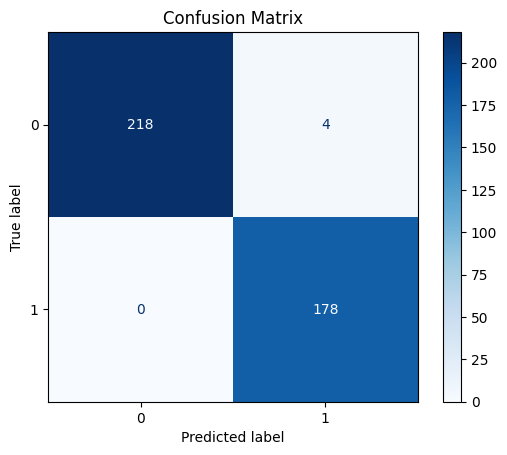

In [62]:
# Predict on the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits and true labels
logits = predictions.predictions
predicted_labels = np.argmax(logits, axis=1)  # Predicted class
true_labels = predictions.label_ids  # True labels

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 5: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)  # Replace unique_labels with your label names
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [63]:
# save the model for later use
torch.save(model.state_dict(), "medical_modle.pth")

### Second fine-tuning

In [83]:
waste_data = pd.read_csv("New_Data/waste_train.csv")

# get the length of section
print("Total number of texts: ", len(waste_data['text']))
print("Total number of labels: ", len(waste_data['label']))

#get number of papers per label
print("The number of papers per label are: ", waste_data['label'].value_counts(normalize=False))


Total number of texts:  40
Total number of labels:  40
The number of papers per label are:  label
1    20
0    20
Name: count, dtype: int64


In [ ]:
# First split: 80% (train+val) and 20% (test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=44)
for train_idx, val_idx in split1.split(waste_data, waste_data['label']):
    waste_train_data = waste_data.iloc[train_idx]
    waste_val_data = waste_data.iloc[val_idx]


# Verify the splits on the labels
print("Train data: ", waste_train_data['label'].value_counts(normalize=False))
print()
print("Validation data: ", waste_val_data['label'].value_counts(normalize=False))
print()
# # Separate the data by label
# label_1_data = waste_data[waste_data['label'] == 1]
# label_0_data = waste_data[waste_data['label'] == 0]

# # Assign 7 papers with label 1 and 1 paper with label 0 to the train set
# waste_train_data = pd.concat([label_1_data.iloc[:10], label_0_data.iloc[:10]])

# # Assign the remaining data to the validation set
# waste_val_data = pd.concat([label_1_data.iloc[10:], label_0_data.iloc[10:]])

# # Print the resulting splits
# print("\nTrain Data:")
# print(waste_train_data['label'].value_counts())
# print("\nValidation Data:")
# print(waste_val_data['label'].value_counts())

Train data:  label
1    10
0    10
Name: count, dtype: int64

Validation data:  label
0    10
1    10
Name: count, dtype: int64



In [85]:
waste_train_dataset = Dataset.from_dict(waste_train_data.to_dict(orient='list'))
waste_val_dataset = Dataset.from_dict(waste_val_data.to_dict(orient='list'))


# Apply tokenization
waste_train_dataset = waste_train_dataset.map(tokenize_function, batched=True)
waste_val_dataset = waste_val_dataset.map(tokenize_function, batched=True)


# Set the format for PyTorch
waste_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
waste_val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Initialize the model
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))
# model = model.to(device)
waste_model = model
# Training arguments
waste_training_args = TrainingArguments(
    output_dir="./temp",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir=None,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Matches the key in compute_metrics
    save_total_limit=2
)

# Define Trainer
waste_trainer = Trainer(
    model=waste_model,
    args=waste_training_args,
    train_dataset=waste_train_dataset,
    eval_dataset=waste_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# Train the model
waste_trainer.train()

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.2762949466705322, 'eval_accuracy': 0.8, 'eval_runtime': 1.3656, 'eval_samples_per_second': 14.645, 'eval_steps_per_second': 0.732, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.2046034336090088, 'eval_accuracy': 0.8, 'eval_runtime': 1.0972, 'eval_samples_per_second': 18.227, 'eval_steps_per_second': 0.911, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.2736018896102905, 'eval_accuracy': 0.7, 'eval_runtime': 1.1024, 'eval_samples_per_second': 18.142, 'eval_steps_per_second': 0.907, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.3114477396011353, 'eval_accuracy': 0.7, 'eval_runtime': 1.1035, 'eval_samples_per_second': 18.124, 'eval_steps_per_second': 0.906, 'epoch': 4.0}
{'loss': 0.0016, 'grad_norm': 0.016145506873726845, 'learning_rate': 1e-05, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.3180792331695557, 'eval_accuracy': 0.8, 'eval_runtime': 1.059, 'eval_samples_per_second': 18.885, 'eval_steps_per_second': 0.944, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.351532220840454, 'eval_accuracy': 0.8, 'eval_runtime': 1.084, 'eval_samples_per_second': 18.45, 'eval_steps_per_second': 0.922, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.3806564807891846, 'eval_accuracy': 0.8, 'eval_runtime': 1.1027, 'eval_samples_per_second': 18.137, 'eval_steps_per_second': 0.907, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.3981800079345703, 'eval_accuracy': 0.8, 'eval_runtime': 1.1043, 'eval_samples_per_second': 18.11, 'eval_steps_per_second': 0.906, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.4074605703353882, 'eval_accuracy': 0.8, 'eval_runtime': 1.099, 'eval_samples_per_second': 18.198, 'eval_steps_per_second': 0.91, 'epoch': 9.0}
{'loss': 0.0009, 'grad_norm': 0.012562733143568039, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.4109361171722412, 'eval_accuracy': 0.8, 'eval_runtime': 1.1328, 'eval_samples_per_second': 17.656, 'eval_steps_per_second': 0.883, 'epoch': 10.0}
{'train_runtime': 43.7852, 'train_samples_per_second': 4.568, 'train_steps_per_second': 0.457, 'train_loss': 0.0012496122159063815, 'epoch': 10.0}


TrainOutput(global_step=20, training_loss=0.0012496122159063815, metrics={'train_runtime': 43.7852, 'train_samples_per_second': 4.568, 'train_steps_per_second': 0.457, 'total_flos': 26493479731200.0, 'train_loss': 0.0012496122159063815, 'epoch': 10.0})

  0%|          | 0/1 [00:00<?, ?it/s]

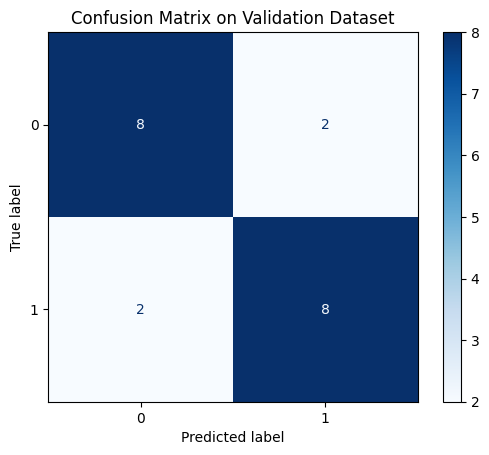

In [86]:
# Predict on the validation dataset
predictions = waste_trainer.predict(waste_val_dataset)

# Extract logits and true labels
logits = predictions.predictions
true_labels = predictions.label_ids
predicted_labels = np.argmax(logits, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=waste_model.config.id2label)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Dataset")
plt.show()

In [87]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8000
Precision: 0.8000
Recall: 0.8000
F1 Score: 0.8000


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

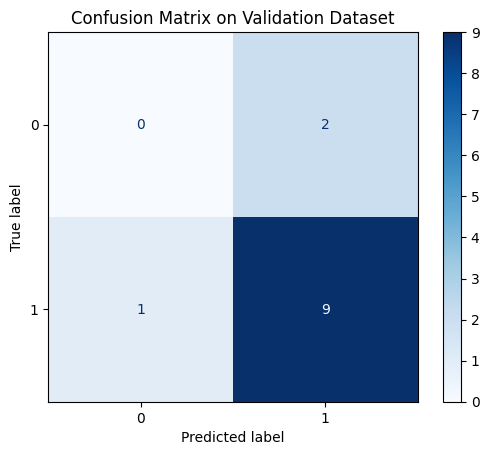

Accuracy: 0.7500
Precision: 0.6818
Recall: 0.7500
F1 Score: 0.7143


In [90]:
new_waste_data = pd.read_csv("New_Data/train.csv")
waste_test_dataset = Dataset.from_dict(new_waste_data.to_dict(orient='list'))


# Apply tokenization
waste_test_dataset = waste_test_dataset.map(tokenize_function, batched=True)


# Set the format for PyTorch
waste_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
predictions = waste_trainer.predict(waste_test_dataset)

# Extract logits and true labels
logits = predictions.predictions
true_labels = predictions.label_ids
predicted_labels = np.argmax(logits, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=waste_model.config.id2label)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Dataset")
plt.show()
# print the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

### infer


In [93]:
import os
import torch
import pandas as pd
import fitz  # PyMuPDF
def extract_text_from_pdf(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        text = ""
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            text += page.get_text()
        return text
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
        return ""

def predict_label_for_pdf(pdf_path, model, tokenizer, device):
    # Extract text from the PDF
    text = extract_text_from_pdf(pdf_path)
    if not text.strip():
        print(f"No text extracted from {pdf_path}")
        return None

    # Tokenize the text
    inputs = tokenizer(
        text, 
        padding="max_length", 
        truncation=True, 
        max_length=512, 
        return_tensors="pt"
    )
    
    # Move tensors to the device (GPU or CPU)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Predict label
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label

def process_pdfs_after_training(directory_path, output_csv, model, tokenizer, device):
    results = []

    # Iterate through all PDF files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(directory_path, filename)
            print(f"Processing {filename}...")

            # Predict label for the PDF
            predicted_label = predict_label_for_pdf(pdf_path, model, tokenizer, device)
            
            if predicted_label is not None:
                results.append({"filename": filename, "predicted_label": predicted_label})

    # Save the results to a CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")

# Directory containing the PDFs
pdfs_dir = "../Medical/waste_data/Yes"
output_csv_path = "../Medical/New_Data/predicted_labels.csv"

# Run the process using the trained model
process_pdfs_after_training(
    directory_path=pdfs_dir,
    output_csv=output_csv_path,
    model=waste_model,       # The model you trained
    tokenizer=tokenizer,     # Tokenizer used during training
    device=device            # Device (GPU or CPU)
)

Processing adetona 2020.pdf...
Processing ajay 2022.pdf...
Processing akpinar 2015.pdf...
Processing amegah 2012.pdf...
Processing Boadi 2005.pdf...
Processing cruz 2023.pdf...
Processing Fakinle 2022.pdf...
Processing golshan 2002.pdf...
Processing Hess 2025.pdf...
Processing Jacobs 1997.pdf...
Processing kamai 2023.pdf...
Processing Kearns 2024.pdf...
Processing Kicinska 2024.pdf...
Processing Mnatzaganian 2015.pdf...
Processing Morsi 2017.pdf...
Processing Pathak 2023.pdf...
Processing Pennington 2022.pdf...
Processing Rappold 2011.pdf...
Processing Silva 2010.pdf...
Processing Uttajig 2021.pdf...
Predictions saved to ../Medical/New_Data/predicted_labels.csv
